In [1]:
# importing required libraries
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
# Define paths to the pre-trained face detection model files
prototxt_path = "Face_Detector/deploy.prototxt"
weights_path = "Face_Detector/res10_300x300_ssd_iter_140000.caffemodel"
face_net = cv2.dnn.readNet(prototxt_path, weights_path)

In [2]:

def build_mask_detector_model():
    """
    This function builds a convolutional neural network (CNN) model for mask detection.

    The model uses a pre-trained MobileNetV2 base model for feature extraction and adds a custom head for classification.
    """
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    # Freeze the base model layers (don't train them)
    for layer in base_model.layers:
        layer.trainable = False

    head_model = base_model.output
    head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
    head_model = Flatten(name="flatten")(head_model)
    head_model = Dense(128, activation="relu")(head_model)
    head_model = Dropout(0.5)(head_model)
    head_model = Dense(1, activation="sigmoid")(head_model)  # Single output unit with sigmoid for binary classification

    model = Model(inputs=base_model.input, outputs=head_model)

    return model

mask_model = build_mask_detector_model()

# Hyperparameters for training
learning_rate = 1e-4
epochs = 20
batch_size = 32  

# Compile the model with binary cross-entropy loss, Adam optimizer, and accuracy metric
mask_model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / epochs), metrics=["accuracy"])

# Data directory path
data_dir = "dataset"

# Define data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Rescale images to [0, 1]
    rotation_range=20,  # Randomly rotate images up to 20 degrees
    zoom_range=0.15,  # Randomly zoom images up to 15%
    width_shift_range=0.2,  # Randomly shift images horizontally up to 20%
    height_shift_range=0.2,  # Randomly shift images vertically up to 20%
    shear_range=0.15,  # Randomly shear images up to 15 degrees
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode="nearest"  # Fill mode for padding during augmentation
)

# Train data generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Resize images to 224x224 for the model
    batch_size=batch_size,
    class_mode="binary"  # Binary classification (masked/not masked)
)

# Validation data generator (no augmentation)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary"
)

# Train the model
history = mask_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator) // batch_size,  # Steps per epoch for training
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator) // batch_size  # Steps per epoch for validation
)

# Save the trained model
mask_model.save("mask_detector.keras")

/var/folders/fx/1pgld95125x514pcbf6f2fkr0000gn/T/ipykernel_28029/1315304878.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Found 7553 images belonging to 2 classes.
Found 7553 images belonging to 2 classes.
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 662ms/step - accuracy: 0.4958 - loss: 0.9009 - val_accuracy: 0.5759 - val_loss: 0.6669
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - accuracy: 0.6143 - loss: 0.7129 - val_accuracy: 0.7634 - val_loss: 0.5307
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.7249 - loss: 0.5520 - val_accuracy: 0.8616 - val_loss: 0.4426
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 536ms/step - accuracy: 0.7543 - loss: 0.4981 - val_accuracy: 0.9152 - val_loss: 0.3812
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 460ms/step - accuracy: 0.8650 - loss: 0.3772 - val_accuracy: 0.9330 - val_loss: 0.3357
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - accuracy: 0.9465 - loss: 0.3066 - val_accuracy: 0.9598 - val_loss: 0.2670
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 465ms/step - accuracy: 0.9258 - loss: 0.2934 - val_accuracy: 0.9509 - val_loss: 0.2567
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 467ms/step - accuracy: 0.9038 - loss: 0.2749 - val_accuracy: 0.9420 - val_loss: 0.2248
Epo

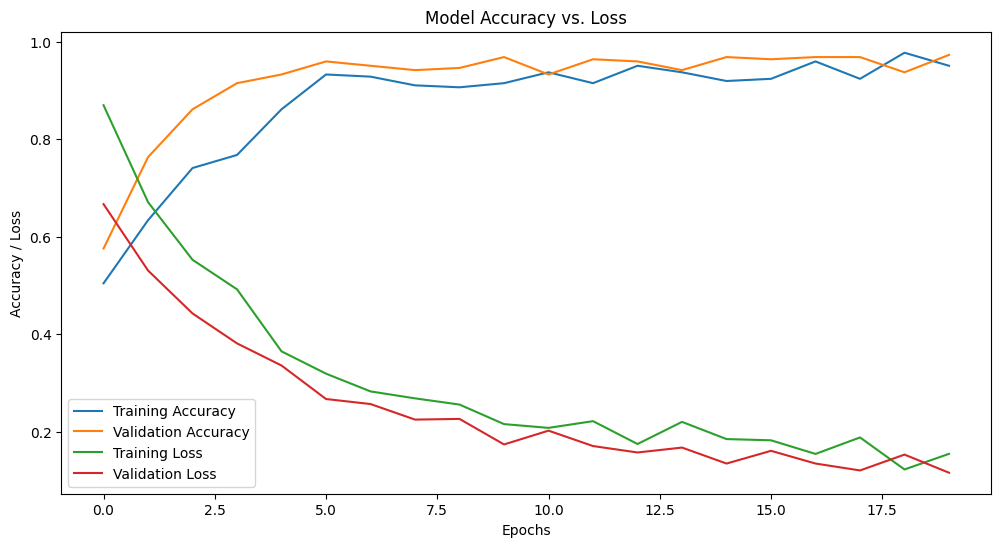

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, f1_score

# Assuming H is the training history object obtained after training the model

# Create a figure with a specific size (12 inches wide, 6 inches high)
plt.figure(figsize=(12, 6))

# Extract training and validation accuracy from the history object
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Extract training and validation loss from the history object
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Set a title for the plot
plt.title('Model Accuracy vs. Loss')

# Label the x-axis (epochs) and y-axis (accuracy/loss)
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')

# Add a legend to differentiate the lines in the plot
plt.legend()

# Display the plot
plt.show()
